/tmp/ipython-input-83411736.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = pd.read_csv("/content/japan_covid_master_data.csv").fillna(method='ffill')
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0014 - val_loss: 0.0297
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0015 - val_loss: 0.0293
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0010 - val_loss: 0.0286
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0011 - val_loss: 0.0277
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0013 - val_loss: 0.0263
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0014 - val_loss: 0.0235
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0013 - val_loss: 0.0214
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0011 - val_loss: 0.0196
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0011 - val_loss: 0.0185
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0011 - val_loss: 0.0181
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 8.3644e-04 - val_loss: 0.0181
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss:

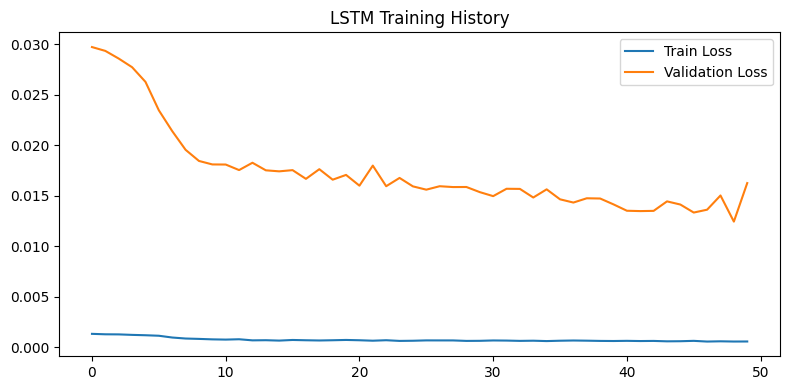

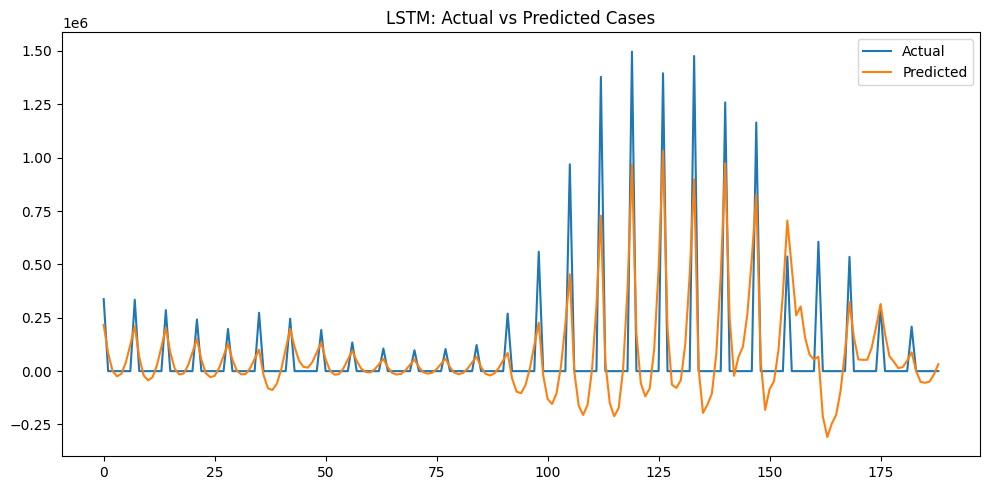

Plots saved to /content/results/
Best model saved to /content/results/lstm_best_model.keras


In [ ]:
# --- LSTM Model for Disease Outbreak Prediction ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, json, math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# === 1. Setup ===
os.makedirs("/output", exist_ok=True)

# === 2. Load and prepare data ===
df = pd.read_csv("../data/japan_covid_master_data.csv").fillna(method='ffill')
data = df['new_cases'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# === 3. Create time-series sequences ===
def create_sequences(data, window=30):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

window = 30
X, y = create_sequences(data_scaled, window)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# === 4. Build the LSTM model ===
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(64),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# === 5. Callbacks ===
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint_path = "/models/lstm_best_model.keras"
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min')

# === 6. Train ===
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint],
    verbose=1
)

# === 7. Evaluate ===
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)

metrics = {"MAE": mae, "RMSE": rmse, "R2": r2}
with open("/output/lstm_metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

print("Metrics saved to /output/lstm_metrics.json")
print(metrics)

# === 8. Plot training history ===
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('LSTM Training History')
plt.tight_layout()
plt.savefig("/output/lstm_training_history.png")
plt.show()

# === 9. Plot predictions ===
plt.figure(figsize=(10,5))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('LSTM: Actual vs Predicted Cases')
plt.legend()
plt.tight_layout()
plt.savefig("/output/lstm_predictions.png")
plt.show()

print("Plots saved to /output")
print("Best model saved to", checkpoint_path)
